In [1]:
import numpy as np
import cortex
subject = 'fsaverage'
surfs = [cortex.polyutils.Surface(*d)
         for d in cortex.db.get_surf(subject, "fiducial")]
numl = surfs[0].pts.shape[0]
numr = surfs[1].pts.shape[0]
num_vertices = numl + numr

Left_Cas = [66381, 107683, 59182, 148775, 162632, 29582, 17511]
Left_V1V2_dorsal = [46966, 39231, 27915, 97023, 112497]
Left_V1V2_ventral = [79681, 66398, 49591, 137341, 114613, 91203, 105278, 118391, 70202]
Left_V2V3_dorsal = [126633, 578, 126605, 52299, 41591, 41591, 61841] #112482
Left_V2V3_ventral = [95425, 107731, 148921, 56056,114647, 28624, 40628]

Right_Cas = [7082, 1375, 161751, 127823, 105127, 48166, 161899]
Right_V1V2_dorsal = [208, 90354, 53155, 111564, 51745, 156689, 51770, 68574]
Right_V1V2_ventral = [40256, 90456, 90438, 75405, 25451, 161956, 40326, 148570]
Right_V2V3_dorsal = [46979, 71809, 28992, 87894, 39009, 112264, 68929, 156634, 73953]
Right_V2V3_ventral = [71835, 32701, 161817, 161829, 40298, 162066, 114309, 90652, 90613]

path_data = np.zeros(num_vertices) * np.nan
for line in [Right_Cas, Right_V1V2_dorsal, Right_V1V2_ventral, Right_V2V3_dorsal, Right_V2V3_ventral]:
    path_length = 0
    paths = []
    path_idx = 1
    for p in range(len(line)-1):
        pt_a, pt_b = line[p], line[p+1]
        np.random.seed(0)
        path = surfs[0].geodesic_path(pt_a, pt_b)
        path_length += len(path)
        paths += path[1:]
    for v in paths:
        v = numl + v
        path_data[v] = path_idx/(path_length+1)
        path_idx += 1

for line in [Left_Cas, Left_V1V2_dorsal, Left_V1V2_ventral, Left_V2V3_dorsal, Left_V2V3_ventral]:
    path_length = 0
    paths = []
    path_idx = 1
    for p in range(len(line)-1):
        pt_a, pt_b = line[p], line[p+1]
        np.random.seed(0)
        path = surfs[0].geodesic_path(pt_a, pt_b)
        path_length += len(path)
        paths += path[1:]
    for v in paths:
        path_data[v] = path_idx/(path_length+1)
        path_idx += 1

/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


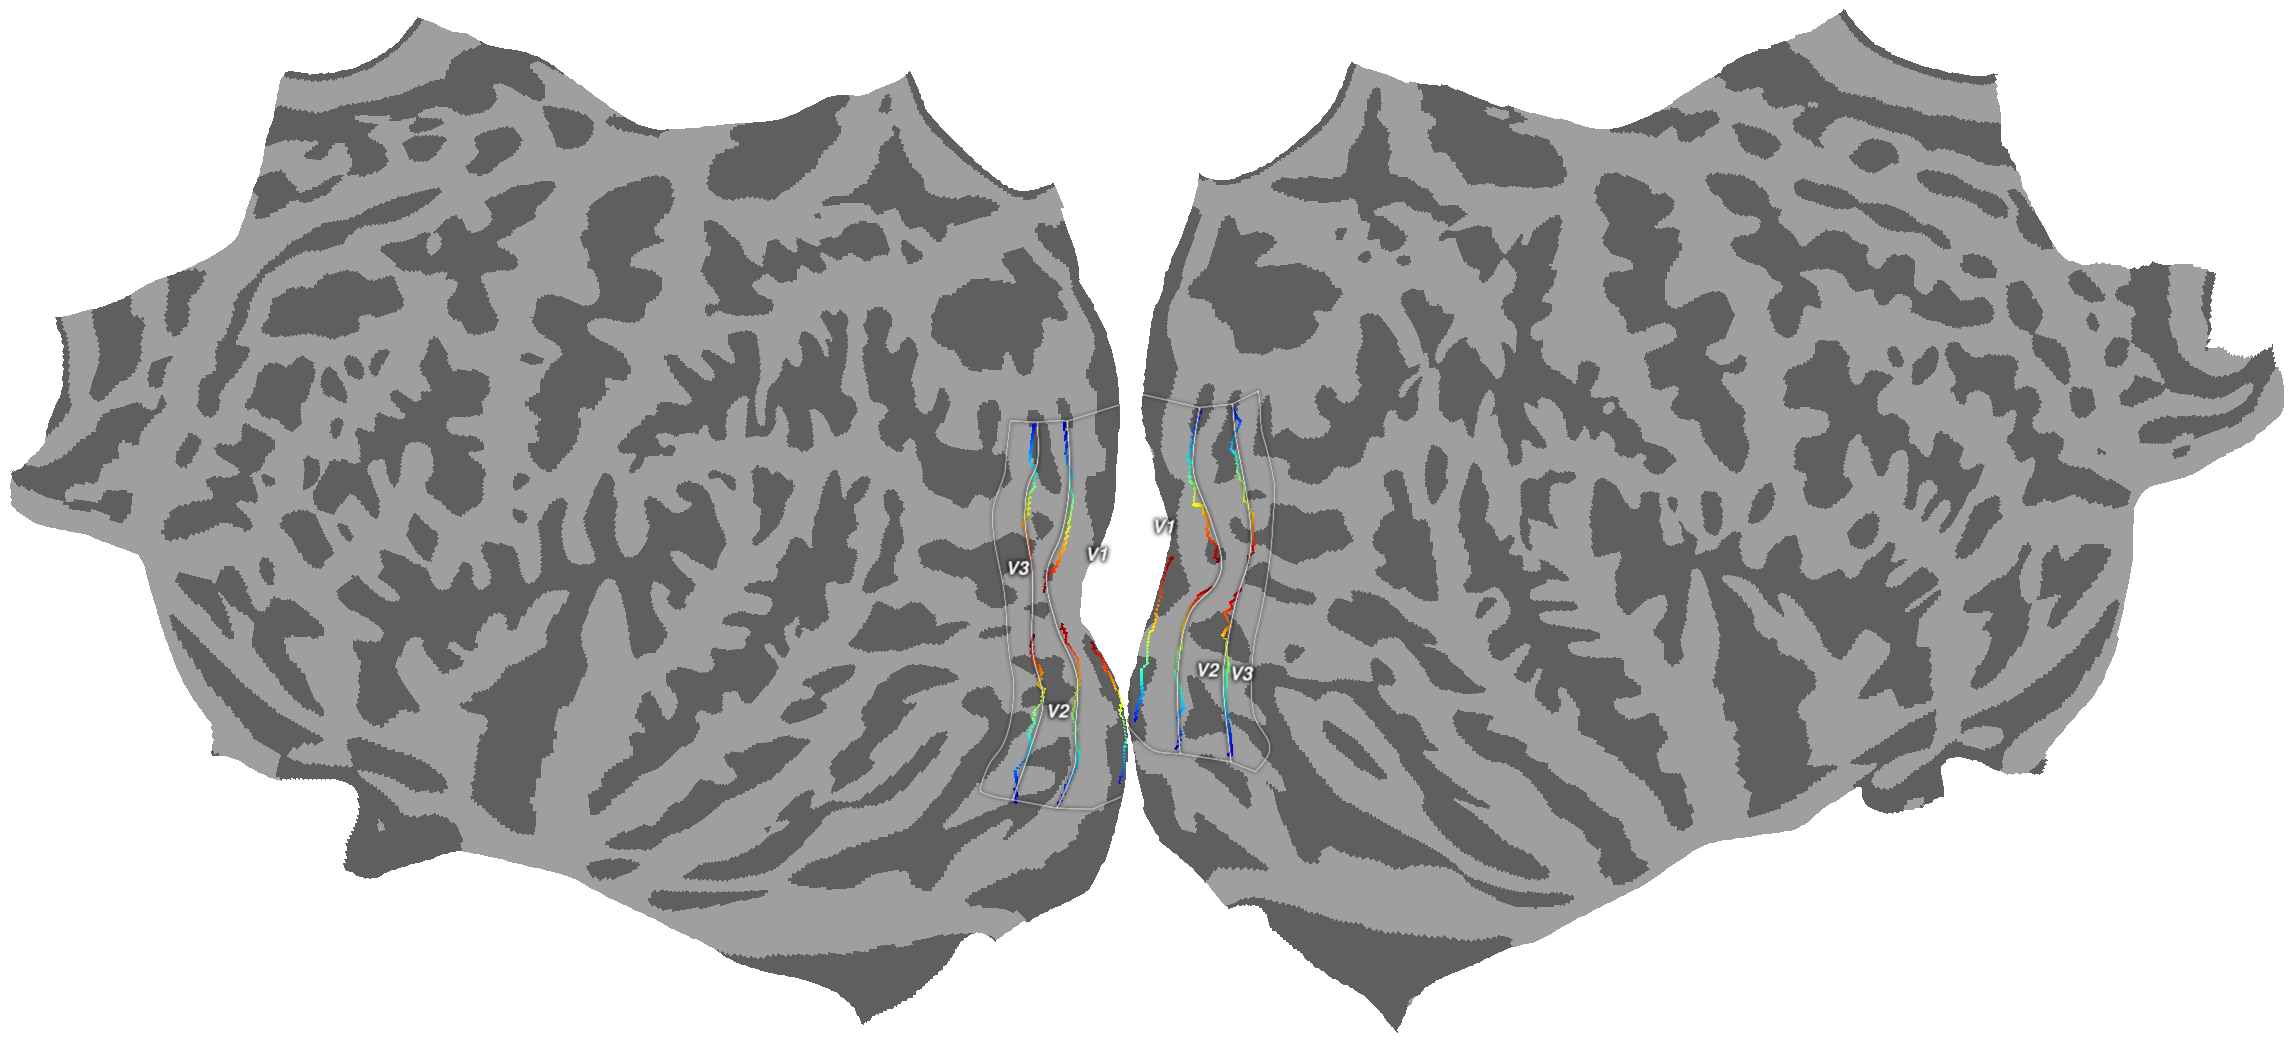

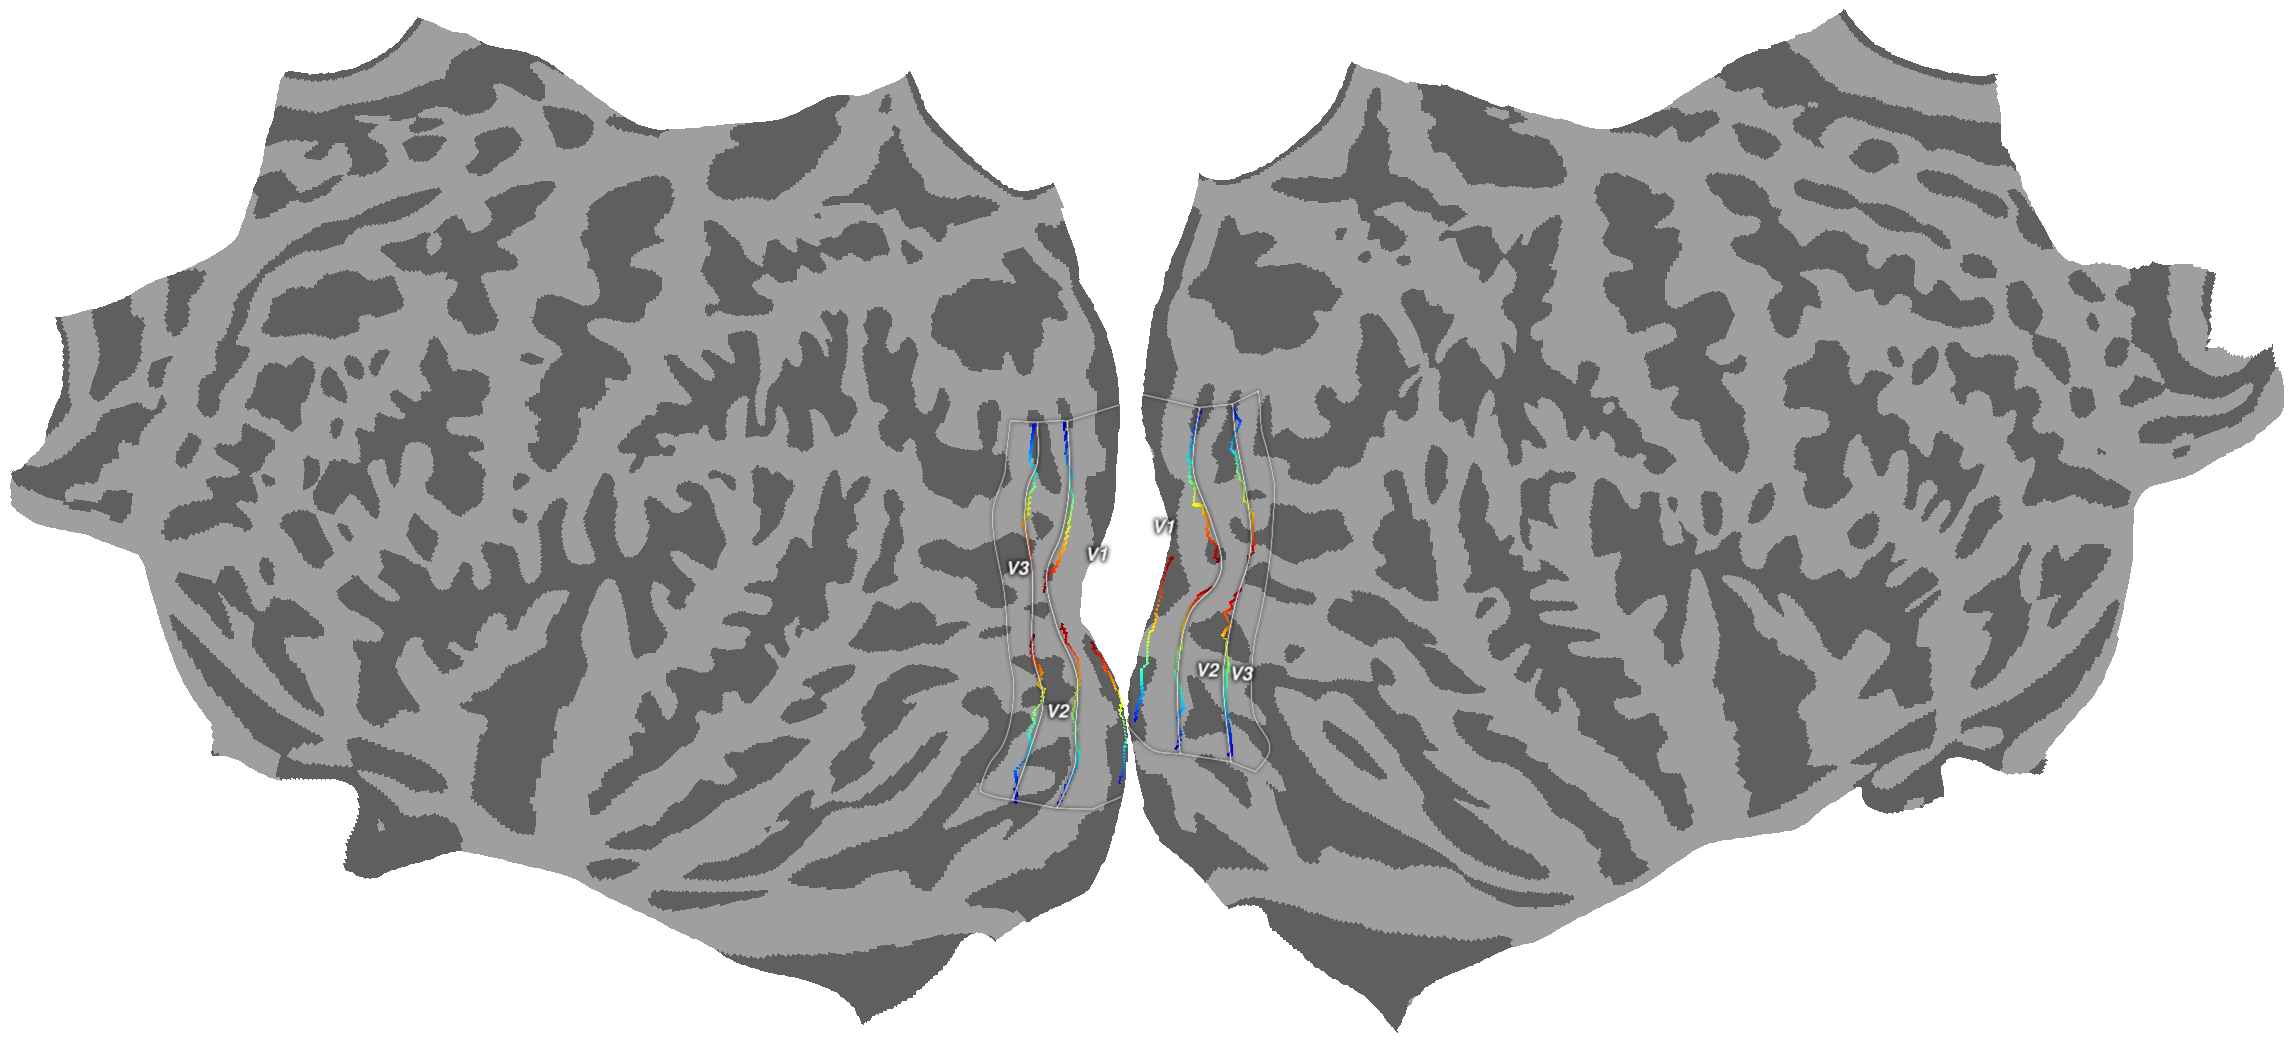

In [2]:
import matplotlib.pyplot as plt
path_verts = cortex.Vertex(path_data, 'fsaverage', cmap="jet_r", vmin=0, vmax=1)
cortex.quickshow(path_verts, with_colorbar=False, with_curvature=True,
                 with_rois=True, roi_list=['V1', 'V2', 'V3'],
                 linecolor=(1.0, 1.0, 1.0, 1.0), linewidth=1)

In [4]:
line_names = ['Right_Cas', 'Right_V1V2_dorsal', 'Right_V1V2_ventral',
              'Right_V2V3_dorsal', 'Right_V2V3_ventral']
for l, line in enumerate([Right_Cas, Right_V1V2_dorsal,
                          Right_V1V2_ventral, Right_V2V3_dorsal, Right_V2V3_ventral]):
    path_data = np.zeros(num_vertices)

    path_length = 0
    paths = []
    path_idx = 1
    path_indices = []
    for p in range(len(line)-1):
        pt_a, pt_b = line[p], line[p+1]
        np.random.seed(0)
        path = surfs[0].geodesic_path(pt_a, pt_b)
        path_length += len(path)
        paths += path[1:]
    paths = np.array(list(set(paths)))
    for v in paths:
        v = numl + v
        path_data[v] = path_idx/(path_length+1)
        path_indices.append(path_idx/(path_length+1))
        path_idx += 1

    root = '../data/visual_field_mapping/cortical_landmarks'
    np.save(f'{root}/paths_{line_names[l]}.npy', path_data)
    np.save(f'{root}/path_indices_{line_names[l]}.npy', np.array(path_indices))

line_names = ['Left_Cas', 'Left_V1V2_dorsal', 'Left_V1V2_ventral',
              'Left_V2V3_dorsal', 'Left_V2V3_ventral']
for l, line in enumerate([Left_Cas, Left_V1V2_dorsal, Left_V1V2_ventral,
                          Left_V2V3_dorsal, Left_V2V3_ventral]):
    path_data = np.zeros(num_vertices)

    path_length = 0
    paths = []
    path_idx = 1
    path_indices = []
    for p in range(len(line)-1):
        pt_a, pt_b = line[p], line[p+1]
        np.random.seed(0)
        path = surfs[0].geodesic_path(pt_a, pt_b)
        path_length += len(path)
        paths += path[1:]
    paths = np.array(list(set(paths)))
    for v in paths:
        path_data[v] = path_idx/(path_length+1)
        path_indices.append(path_idx/(path_length+1))
        path_idx += 1
    root = '../data/visual_field_mapping/cortical_landmarks'
    np.save(f'{root}/paths_{line_names[l]}.npy', path_data)
    np.save(f'{root}/path_indices_{line_names[l]}.npy', np.array(path_indices))

In [2]:


import os
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cortex
import pickle
from scipy.sparse import csr_matrix

def vol2surf(subject, stat):
    vol_data = cortex.Volume(stat.transpose(2,1,0), subject, 'NatPAC')
    mapper = cortex.get_mapper(subject, 'NatPAC', 'nearest')
    vertex_map = mapper(vol_data)

    mats = cortex.db.get_mri_surf2surf_matrix(subject=subject,
                                        surface_type='inflated',
                                        target_subj='fsaverage')

    left_transform = csr_matrix(mats[0])
    right_transform = csr_matrix(mats[1])
    vertex_map_fs_left = left_transform.dot(vertex_map.left)
    vertex_map_fs_right = right_transform.dot(vertex_map.right)
    vertex_map_fs = np.concatenate([vertex_map_fs_left, vertex_map_fs_right])
    return vertex_map_fs, vertex_map_fs_left, vertex_map_fs_right
# plotting group-averaged subject in fsaverage
subjects = ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008',
            'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016',
            'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022',
            'sub-023', 'sub-024', 'sub-PBJ']

In [11]:
from scipy.stats import circmean
def circsubstract(a, b):
    diff = a - b
    diff = (diff+180) % 360 - 180
    return abs(diff)

line_names = ['Right_Cas', 'Right_V1V2_dorsal', 'Right_V1V2_ventral',
              'Right_V2V3_dorsal', 'Right_V2V3_ventral', 'Left_Cas',
              'Left_V1V2_dorsal', 'Left_V1V2_ventral', 'Left_V2V3_dorsal', 'Left_V2V3_ventral']
line_target_PA = [180, 270, 90, 180, 180, 0, 270, 90, 0, 0]

n_bins = 1
bin_edges = np.linspace(0, 1, n_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

subject_pRF_PA_data = np.zeros((len(subjects), len(line_names), n_bins))
for s, subject in enumerate(subjects):
    pRF_map = nib.load(f'../../data/visual_field_mapping/pRF_results/{subject}_params_ang.nii').get_fdata()
    pRF_map_surf, _, _ = vol2surf(subject, pRF_map)
    for l, line_name in enumerate(line_names):
        root = '../../data/visual_field_mapping/cortical_landmarks'
        path_data = np.load(f'{root}/paths_{line_name}.npy')
        path_indices = np.load(f'{root}/path_indices_{line_name}.npy')

        path_data_sorted = path_data[path_data>0]
        path_PA_values = pRF_map_surf[path_data>0]

        bin_indices = np.digitize(path_data_sorted, bin_edges) - 1
        binned_means = [circsubstract(line_target_PA[l], circmean(path_PA_values[bin_indices == i], high=360))
                        if np.any(bin_indices == i) else np.nan for i in range(n_bins)]

        subject_pRF_PA_data[s,l,:] = binned_means
mean_subject_pRF_PA_data = np.mean(subject_pRF_PA_data, axis=1)

gaze_types = ['mocet', 'polynomial', 'linear', 'uncorrected']
subject_minecraft_PA_data = np.zeros((len(gaze_types), len(subjects), len(line_names), n_bins))
for g, gaze_type in enumerate(gaze_types):
    for s, subject in enumerate(subjects):
        pRF_map = nib.load(f'../../data/visual_field_mapping/freeviewing_results/{subject}_{gaze_type}_ang.nii').get_fdata()
        pRF_map_surf, _, _ = vol2surf(subject, pRF_map)
        for l, line_name in enumerate(line_names):
            root = '../../data/visual_field_mapping/cortical_landmarks'
            path_data = np.load(f'{root}/paths_{line_name}.npy')
            path_indices = np.load(f'{root}/path_indices_{line_name}.npy')

            path_data_sorted = path_data[path_data>0]
            path_PA_values = pRF_map_surf[path_data>0]

            bin_indices = np.digitize(path_data_sorted, bin_edges) - 1
            binned_means = [circsubstract(line_target_PA[l], circmean(path_PA_values[bin_indices == i], high=360))
                            if np.any(bin_indices == i) else np.nan for i in range(n_bins)]

            subject_minecraft_PA_data[g,s,l,:] = binned_means
mean_subject_minecraft_PA_data = np.mean(subject_minecraft_PA_data, axis=2)

In [12]:
from scipy.stats import ttest_rel
print([np.mean(mean_subject_minecraft_PA_data[g], axis=0) for g in range(len(gaze_types))])
print(ttest_rel(mean_subject_pRF_PA_data, mean_subject_minecraft_PA_data[1]))
print(ttest_rel(mean_subject_minecraft_PA_data[0], mean_subject_minecraft_PA_data[1]))
print(ttest_rel(mean_subject_minecraft_PA_data[0], mean_subject_minecraft_PA_data[2]))
print(ttest_rel(mean_subject_minecraft_PA_data[0], mean_subject_minecraft_PA_data[3]))

[array([41.24874828]), array([50.93194244]), array([60.91524263]), array([61.82335838])]
TtestResult(statistic=array([-4.47683926]), pvalue=array([0.00033179]), df=array([17]))
TtestResult(statistic=array([-2.1516835]), pvalue=array([0.04608857]), df=array([17]))
TtestResult(statistic=array([-3.68049476]), pvalue=array([0.00185475]), df=array([17]))
TtestResult(statistic=array([-5.10940148]), pvalue=array([8.72151132e-05]), df=array([17]))


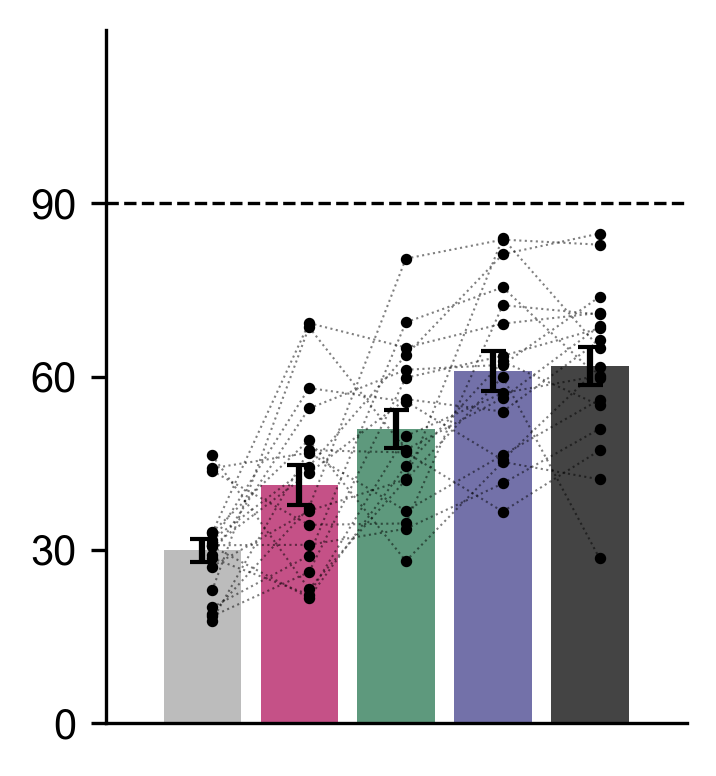

In [13]:
from scipy.stats import ttest_rel, sem
plt.style.use('default')
fig, axes = plt.subplots(1,1, sharey=True, sharex=True, figsize=(2.5,3), dpi=300)
color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

axes.bar(0, np.mean(mean_subject_pRF_PA_data, axis=0),
         yerr=sem(mean_subject_pRF_PA_data, axis=0),
         color = '#bcbcbc', capsize=3) # '#4e69a2', '#e5b056'

axes.bar(np.arange(1, len(gaze_types)+1),
         [np.mean(mean_subject_minecraft_PA_data[g], axis=0)[0] for g in range(len(gaze_types))],
         yerr= [sem(mean_subject_minecraft_PA_data[g], axis=0)[0] for g in range(len(gaze_types))],
         color = color_list, capsize=3)

axes.scatter((0)*np.ones(len(subjects))+0.1, mean_subject_pRF_PA_data, s=3, c='k')
for t, tag in enumerate(gaze_types):
    axes.scatter((t+1)*np.ones(len(subjects))+0.1, mean_subject_minecraft_PA_data[t], s=3, c='k')
for s, subject in enumerate(subjects):
    axes.plot([0+0.1, 1+0.1], [mean_subject_pRF_PA_data[s], mean_subject_minecraft_PA_data[0][s]],
              c='k', alpha=0.5, lw=0.5, linestyle=':')
    for g in range(len(gaze_types)-1):
        axes.plot([g+1+0.1, g+2+0.1], [mean_subject_minecraft_PA_data[gg][s] for gg in [g,g+1]],
                       c='k', alpha=0.5, lw=0.5, linestyle=':')

axes.axhline(90, c='k', lw=0.8, linestyle='--')
axes.set_ylim(0.0, 120)
axes.set_yticks([0,30,60,90])
axes.set_xlim(-1,5)
axes.set_xticks([0,1,2,3,4])
axes.set_xticks([])
axes.set_xticklabels([])
axes.spines[['top', 'right']].set_visible(False)
plt.subplots_adjust(wspace=0.08)

for tick in axes.get_yticklabels():
    tick.set_fontname("Arial")
for tick in axes.get_xticklabels():
    tick.set_fontname("Arial")